In [1]:
import pandas as pd
import numpy as np
from scipy.special import softmax
import scipy.stats as st

# 2. Markov Metaphor

I like to think of the Markov chain probabilities as the percentage of fans that leave one team for another after the two teams play. With that in mind, each game actually becomes two probabilities. One of the probabilities is the percentage of fans that left the losing team for the winning team, and the other, much lower, probability is the percentage of fans that left the winning team for the losing team. In this fashion, each game provides as much information as possible for the rankings. This is also easier to conceptualize than the Stanley Cup model that we talked about in class since the values in the transition matrix are, by necessity, probabilities and not binary like in the cup model. This also allows for the alpha values to be conceptualized more easily. For example, even though UVA may never play Oregon, there is a slight percentage of UVA fans who could leave UVA for Oregon on any given week/game and vice versa. The same is true for every single team combination, so our transition matrix reflects that.

## Clean & Create Columns for Ranking

In [2]:
scores = pd.read_csv('SB_box_scores_2019_without_rank.csv').drop(['Wk', 'Date', 'Rk', 'Time', 'Day', 'Notes'], axis=1)
scores.head()

,Winner,Pts_winner,X8,Loser,Pts_loser
0,Florida,24,N,Miami (FL),20
1,Hawaii,45,NaN,Arizona,38
2,Alabama-Birmingham,24,NaN,Alabama State,19
3,Arizona State,30,NaN,Kent State,7
4,Bowling Green State,46,NaN,Morgan State,3


In [3]:
scores.X8.value_counts()

X8
@    287
N     60
Name: count, dtype: int64

In [4]:
#remap home, away, and neutral games
scores['X8'] = scores.X8.map({'N':'N', '@':'A', np.nan:'H'})
scores.X8.value_counts()

X8
H    541
A    287
N     60
Name: count, dtype: int64

In [5]:
scores.head()

,Winner,Pts_winner,X8,Loser,Pts_loser
0,Florida,24,N,Miami (FL),20
1,Hawaii,45,H,Arizona,38
2,Alabama-Birmingham,24,H,Alabama State,19
3,Arizona State,30,H,Kent State,7
4,Bowling Green State,46,H,Morgan State,3


In [16]:
#get a list of teams
teams = pd.Series(list(scores.Winner.unique()) + list(scores.Loser.unique())).unique()
len(teams)

217

# 3. Calculating Probabilities

I have chosen to calculate my probabilities based on the score differential of each game. This does come with some imperfections. The main two that I would take into account in the future are blowout games and home and away status. Blowout games can result in very different probabilities of victory in a model based on score differential as a game won by 52 is valued a lot more than a game won by 42, even though both are sure victories. Potentially introducing a cap on score differential might alleviate this, or transforming score differential with a log function or an exponential function with a power less than 1 could as well. If I had more time, I would also like to factor home and away status into the calculation somehow, as teams have an advantage at home and the rankings should reflect that.

In [17]:
#get the score differential of each game
scores['Score_diff'] = scores['Pts_winner'] - scores['Pts_loser']

<Axes: >

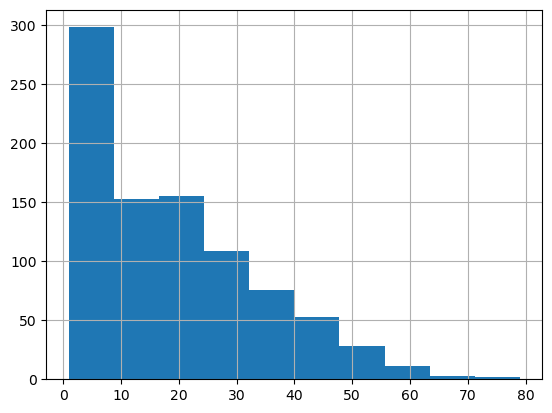

In [18]:
scores.Score_diff.hist()

In [19]:
#obtain the two values that we will use to calculate our probabilities
scores['Softmax'] = softmax(scores.Score_diff)
scores['Prop'] = scores.Score_diff / sum(scores.Score_diff)

In [20]:
scores.head(5)

,Winner,Pts_winner,X8,Loser,Pts_loser,Score_diff,Softmax,Prop
0,Florida,24,N,Miami (FL),20,4,2.673508e-33,0.000236
1,Hawaii,45,H,Arizona,38,7,5.369884e-32,0.000412
2,Alabama-Birmingham,24,H,Alabama State,19,5,7.267347e-33,0.000295
3,Arizona State,30,H,Kent State,7,23,4.771738e-25,0.001355
4,Bowling Green State,46,H,Morgan State,3,43,2.315081e-16,0.002534


count    8.880000e+02
mean     1.126126e-03
std      3.349349e-02
min      1.331061e-34
25%      5.369884e-32
50%      4.351262e-28
75%      1.925056e-22
max      9.980851e-01
Name: Softmax, dtype: float64


<Axes: >

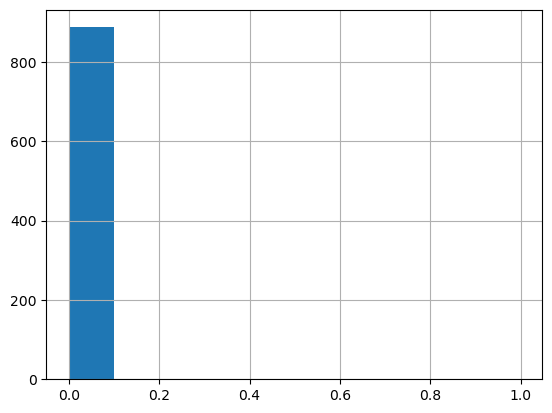

In [21]:
print(scores.Softmax.describe())
scores.Softmax.hist(bins=10)

count    888.000000
mean       0.001126
std        0.000881
min        0.000059
25%        0.000412
50%        0.000943
75%        0.001709
max        0.004655
Name: Prop, dtype: float64


<Axes: >

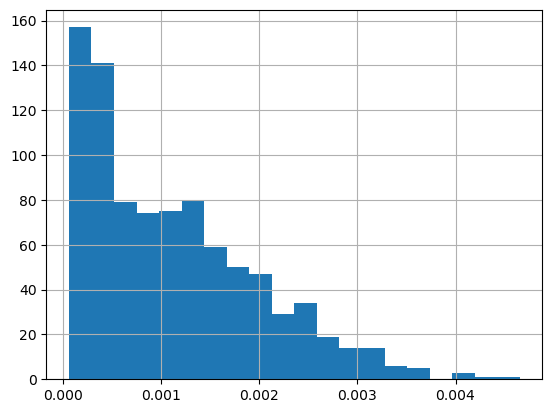

In [22]:
print(scores.Prop.describe())
scores.Prop.hist(bins=20)

# 3 & 4. Calculating Probabilities & Irreducibility

The code below actually calculates the transition matrix probabilities based on either the score differential proportion or the score differential softmax values. It then places an alpha value of your choice in every matchup for which we do not have information. This ensures that the transition matrix will be able to reach a steady state and won't enter into a loop, making it irreducible.

## Functions for Ranking Calculation

In [23]:
def matrix_maker(df, col, alpha):
    #create an empty matrix
    trans_matrix = pd.DataFrame(np.nan, index=teams, columns=teams)
    #obtain the z score of each value in order to slightly normalize the rankings
    z = st.zscore(df[col])
    #calculate the cdf of the z scores to get a probability of victory, divide by 2
    z_probs = st.norm.cdf(z) / 2
    df['z_probs'] = z_probs
    
    #input the above probability of victory and its complement into the correct locations, ensuring the winner's
    #probability is above .5 while the loser's is below .5
    for i, row in df.iterrows():
        trans_matrix.loc[row.Winner, row.Loser] = 0.5 + row.z_probs
        trans_matrix.loc[row.Loser, row.Winner] = 1 - (row.z_probs + 0.5)
    
    #normalize the matrix so each column sums to 1
    for i in trans_matrix:
        trans_matrix[i] = trans_matrix[i] / trans_matrix[i].sum(axis=0)

    teams_n = len(df)
    
    #input our alpha values into the matrix
    for i in trans_matrix:
        team = trans_matrix[i]
        #how many games have to get probabilities? how many don't?
        to_fill = sum(team.isna())
        games = sum(team.notnull())
        #how much probability will we give to other games?
        filled_prob = alpha * to_fill
        #subtract how much you filled from the games that you didn't have to fill in equal proportion
        trans_matrix[i] = trans_matrix[i] - (filled_prob / games)
        trans_matrix[i] = trans_matrix[i].fillna(alpha)
        
    return trans_matrix

In [43]:
def rank_teams(matrix, reps):
    initial_prob = pd.DataFrame(1/len(matrix), index=matrix.index, columns=['probability'])
    vector = matrix @ initial_prob
    for i in range(reps-1):
        vector = matrix @ vector
    rank_probs = vector.sort_values('probability', ascending=False).reset_index()
    rank_probs['New Rank'] = range(1, len(rank_probs)+1)
    return rank_probs

# 5. Ranking

In [54]:
trans_matrix = matrix_maker(scores, 'Softmax', 0.000001)
new_ranking = rank_teams(trans_matrix, 10000)#[0:25]
original_rank = pd.DataFrame({'Team': ['Louisiana State',
                                      'Clemson',
                                       'Ohio State',
                                       'Georgia',
                                       'Oregon',
                                       'Florida',
                                       'Oklahoma',
                                       'Alabama',
                                       'Penn State',
                                       'Minnesota',
                                       'Wisconsin',
                                       'Notre Dame',
                                       'Baylor',
                                       'Auburn',
                                       'Iowa',
                                       'Utah',
                                       'Memphis',
                                       'Michigan',
                                       'Appalachian State',
                                       'Navy',
                                       'Cincinnati',
                                       'Air Force', 
                                       'Boise State',
                                       'Central Florida',
                                       'Texas'
                                      ],
                              'AP Poll': list(range(1, 26))})

In [71]:
rankings = pd.merge(new_ranking, original_rank, left_on='index', right_on='Team', how='right')\
    .drop('index', axis=1)[['Team', 'New Rank', 'probability', 'AP Poll']]\
    .set_index('Team').sort_values('New Rank')

rankings['Difference'] = rankings['AP Poll'] - rankings['New Rank']
rankings.style.background_gradient(axis=0, subset=['Difference'], cmap='coolwarm',
                                   vmin=-max(abs(rankings['Difference'].min()), abs(rankings['Difference'].max())),
                                   vmax=max(abs(rankings['Difference'].min()), abs(rankings['Difference'].max())))

,New Rank,probability,AP Poll,Difference
Team,,,,
Louisiana State,1,0.023049,1,0
Georgia,2,0.017421,4,2
Clemson,3,0.016417,2,-1
Ohio State,4,0.015161,3,-1
Auburn,5,0.014154,14,9
Florida,6,0.013837,6,0
Oregon,7,0.013614,5,-2
Penn State,8,0.013207,9,1
Wisconsin,9,0.012614,11,2


These rankings look pretty good for the most part! The biggest outlier is Auburn at 5. I think Auburn at 9-4 is ranked higher than they should be because I chose to use score differential. A majority of Auburn's wins are huge blowouts, winning by almost 40 at times, but their biggest loss is only by 11 and their other losses are all by 7 or less. If I mitigate the effect of blowout games in the future, we might not see Auburn so high, and the ranking will likely be more accurate.